In [ ]:
#Allow Colab notebook to access files on Google Drive

from google.colab import drive
drive.mount('/content/drive')

Citation: The code for this fine-tuning procedure is largely modeled off of the following tutorial: https://huggingface.co/docs/transformers/tasks/sequence_classification

# Data Processing

In [ ]:
#Installations from the huggingface library

!pip install transformers datasets evaluate

In [ ]:
##NOTE: The below code was run once to save a consistent permutation but need not be run again

# permutn=np.random.permutation(dsize) ##This was only run the first time
# np.save('/content/drive/MyDrive/CompLingFinalProject/permutn_on_input_data.npy',permutn)

In [ ]:
##Create huggingface Dataset objects corresponding to the training, validation, and test sets

from datasets import Dataset
import numpy as np

#Adjust file names as appropriate
with open('/content/drive/MyDrive/CompLingFinalProject/complete_eli5_chatgpt_responses_cleaned.txt','r') as gpt, open('/content/drive/MyDrive/CompLingFinalProject/complete_true_eli5_chatgpt_responses.txt', 'r') as reddit: 
  
  #Extract and organize saved data
  glines=gpt.readlines()
  rlines=reddit.readlines()
  all_data,all_labels=[],[]
  for i in glines:
    all_data.append(i.replace('\n',''))
  for j in rlines:
    all_data.append(j.replace('\n',''))
  glabels=[0 for ind in range(len(glines))] #ChatGPT responses labeled with 0
  rlabels=[1 for ind in range(len(rlines))] #Reddit responses labeled with 1
  for i in glabels:
    all_labels.append(i)
  for j in rlabels:
    all_labels.append(j)
  all_data_shuffled,all_labels_shuffled=[],[]
  dsize=len(all_data)
  
  #Randomly permute the data to avoid any possible bias in the splits
  permutn=np.load('/content/drive/MyDrive/CompLingFinalProject/permutn_on_input_data.npy')
  for p in permutn:
    all_data_shuffled.append(all_data[p])
    all_labels_shuffled.append(all_labels[p])

  # 80% train, 10% val, 10% test
  ds_train=Dataset.from_dict({'text':all_data_shuffled[:-dsize//5], 'label':all_labels_shuffled[:-dsize//5]})
  ds_val=Dataset.from_dict({'text':all_data_shuffled[-dsize//5:-dsize//10], 'label':all_labels_shuffled[-dsize//5:-dsize//10]})
  ds_test=Dataset.from_dict({'text':all_data_shuffled[-dsize//10:], 'label':all_labels_shuffled[-dsize//10:]})

In [ ]:
#Tokenize datasets and instantiate DataCollatorWithPadding object

from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)
tokenized_ds_train = ds_train.map(preprocess_function, batched=True)
tokenized_ds_val = ds_val.map(preprocess_function, batched=True)
tokenized_ds_test = ds_test.map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/26560 [00:00<?, ? examples/s]

Map:   0%|          | 0/3320 [00:00<?, ? examples/s]

Map:   0%|          | 0/3321 [00:00<?, ? examples/s]

# Fine-Tuning DistilBERT

In [ ]:
#Define accuracy as a metric to be computed by the model during training

import evaluate

accuracy = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

id2label = {0: "CHATGPT", 1: "HUMAN"}
label2id = {"HUMAN": 0, "CHATGPT": 1}



In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

#Define architecture using pretrained DistilBERT
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

#Define hyperparameters for training
training_args = TrainingArguments(
    output_dir="chatgpt_eli5_text_classifier_v2",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)

#Instantiate Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds_train,
    eval_dataset=tokenized_ds_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

#Begin training
trainer.train()

In [ ]:
#Save the newly-trained model to huggingface. Note that this requires an account

from huggingface_hub import notebook_login

notebook_login()
trainer.push_to_hub()

# Testing Fine-Tuned Model

In [ ]:
#Download fine-tuned model from huggingface.

from transformers import pipeline

classifier = pipeline(model="RafiBrent/chatgpt_eli5_text_classifier_v2")

In [ ]:
#Evaluate the model's performance on the test set

true_pos,false_pos,true_neg,false_neg=0,0,0,0
failed_count=0
for ind in range(len(tokenized_ds_test)):
  if ind!=0 and ind%100==0:
    print(ind)
    print((true_pos+true_neg)/(true_pos+true_neg+false_pos+false_neg))

  #If inputs exceed the maximum length accepted by the model, they must be discarded
  try:
    pred=classifier(tokenized_ds_test[ind]['text'])[0]
  except:
    failed_count+=1
    continue

  if pred['label']=='CHATGPT' and tokenized_ds_test[ind]['label']==0:
    true_neg+=1
  elif pred['label']=='CHATGPT' and tokenized_ds_test[ind]['label']==1:
    false_neg+=1
  elif pred['label']=='HUMAN' and tokenized_ds_test[ind]['label']==0:
    false_pos+=1
  elif pred['label']=='HUMAN' and tokenized_ds_test[ind]['label']==1:
    true_pos+=1

print('number of inputs that were not successfully computed: ' + str(failed_count))

#Print overall accuracy on the test set
print((true_pos+true_neg)/(true_pos+true_neg+false_pos+false_neg))

# Graphical Analysis

In [ ]:
#Access model from huggingface 

from transformers import AutoModelForSequenceClassification

my_tokenizer=AutoTokenizer.from_pretrained("RafiBrent/chatgpt_eli5_text_classifier_v2")
model = AutoModelForSequenceClassification.from_pretrained("RafiBrent/chatgpt_eli5_text_classifier_v2")


In [ ]:
#Assemble predicted probabilities and true labels

probs_arr=[] #probability that the text is human-generated
labels_arr=[]
import torch
from torch import nn
s=nn.Sigmoid()
with torch.no_grad():
  for ind in range(len(ds_test)):
    inputs=tokenizer(ds_test[ind]['text'], return_tensors='pt')
    try:
      probs_arr.append(s(model(**inputs).logits[0,1]))
      labels_arr.append(ds_test[ind]['label'])
    except:
      continue

[tensor(0.9779), tensor(0.9706), tensor(0.3373), tensor(0.6105), tensor(0.0453), tensor(0.9730), tensor(0.2750), tensor(0.8420), tensor(0.9753), tensor(0.0491), tensor(0.9536), tensor(0.0428), tensor(0.0470), tensor(0.9188), tensor(0.7839), tensor(0.0435), tensor(0.9156), tensor(0.0408), tensor(0.9656), tensor(0.9785), tensor(0.9723), tensor(0.9740), tensor(0.9823), tensor(0.9368), tensor(0.9642), tensor(0.0445), tensor(0.9810), tensor(0.9736), tensor(0.9634), tensor(0.9491), tensor(0.0434), tensor(0.0415), tensor(0.9797), tensor(0.9684), tensor(0.0422), tensor(0.9783), tensor(0.8842), tensor(0.9832), tensor(0.9783), tensor(0.8540), tensor(0.9497), tensor(0.9694), tensor(0.9763), tensor(0.1816), tensor(0.0410), tensor(0.0746), tensor(0.0465), tensor(0.9160), tensor(0.9788), tensor(0.8972), tensor(0.0433), tensor(0.0449), tensor(0.9541), tensor(0.9032), tensor(0.0415), tensor(0.2457), tensor(0.7402), tensor(0.0458), tensor(0.0417), tensor(0.0476), tensor(0.0421), tensor(0.9407), tensor(

In [ ]:
#Save model results at 20 different classification thresholds

true_pos_test,false_pos_test,true_neg_test,false_neg_test=0,0,0,0
roc_results=np.zeros((21,4))#true_neg,false_neg,false_pos,true_pos
failed_count=0
for threshold in np.arange(21)/20:
  for ind in range(len(probs_arr)):
    if probs_arr[ind]<threshold and labels_arr[ind]==0:
      roc_results[int(20*threshold),0]+=1
    elif probs_arr[ind]<threshold and labels_arr[ind]==1:
      roc_results[int(20*threshold),1]+=1
    elif probs_arr[ind]>=threshold and labels_arr[ind]==0:
      roc_results[int(20*threshold),2]+=1
    elif probs_arr[ind]>=threshold and labels_arr[ind]==1:
      roc_results[int(20*threshold),3]+=1

In [ ]:
#Compute AUC for the model

from sklearn.metrics import auc
fpr=roc_results[:,2]/(roc_results[:,2]+roc_results[:,0])
tpr=roc_results[:,3]/(roc_results[:,3]+roc_results[:,1])


print(auc(fpr, tpr))

0.9966670624353341


Text(0, 0.5, 'number of data points')

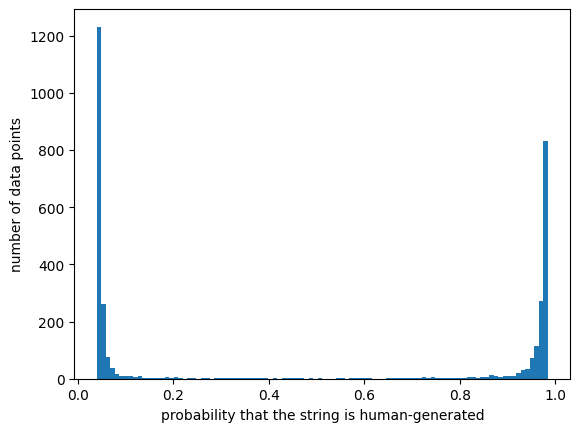

In [ ]:
#Histogram of predicted probabilities for the fine-tuned model

plt.hist(probs_arr, bins=100)
plt.xlabel('probability that the string is human-generated')
plt.ylabel('number of data points')

Text(0, 0.5, 'true positive rate')

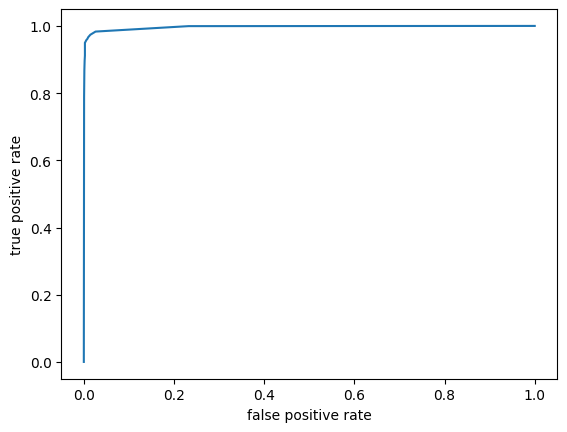

In [ ]:
#ROC curve for the fine-tuned model

import matplotlib.pyplot as plt
plt.plot(fpr,tpr)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

Text(0.5, 1.0, 'DistilBERT fine-tuned for our dataset')

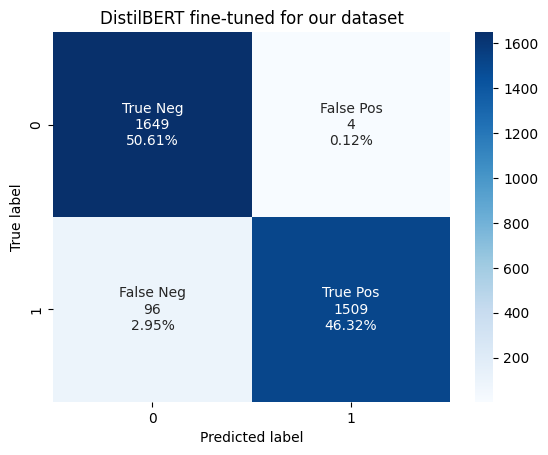

In [ ]:
#Confusion matrix for the model

import seaborn as sns
import matplotlib.pyplot as plt

cf_mat=np.array([[true_neg_test,false_pos_test],[false_neg_test,true_pos_test]])

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_mat.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_mat.flatten()/np.sum(cf_mat)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_mat, annot=labels, fmt='', cmap='Blues')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('DistilBERT fine-tuned for our dataset')

Text(0.5, 1.0, 'OpenAI classifier on separate challenge dataset')

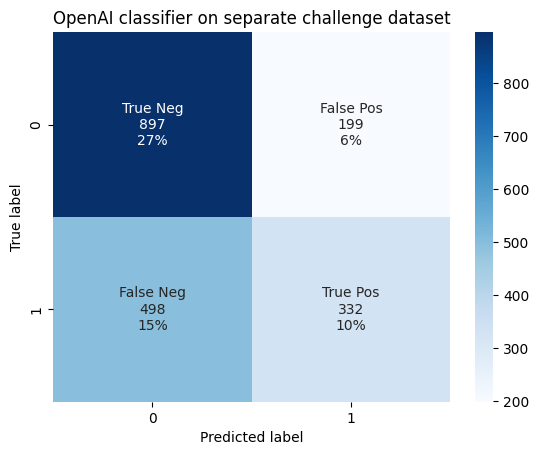

In [ ]:
#Confusion matrix for OpenAI classifier on "challenge dataset". Percentages do not add up to 100 because the model failed to assert a classification for 42% of the data.


cf_mat=np.array([[897,199],[498,332]])

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_mat.flatten()]
group_percentages = ['27%','6%','15%','10%']
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_mat, annot=labels, fmt='', cmap='Blues')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('OpenAI classifier on separate challenge dataset')